In [35]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *
from render import *

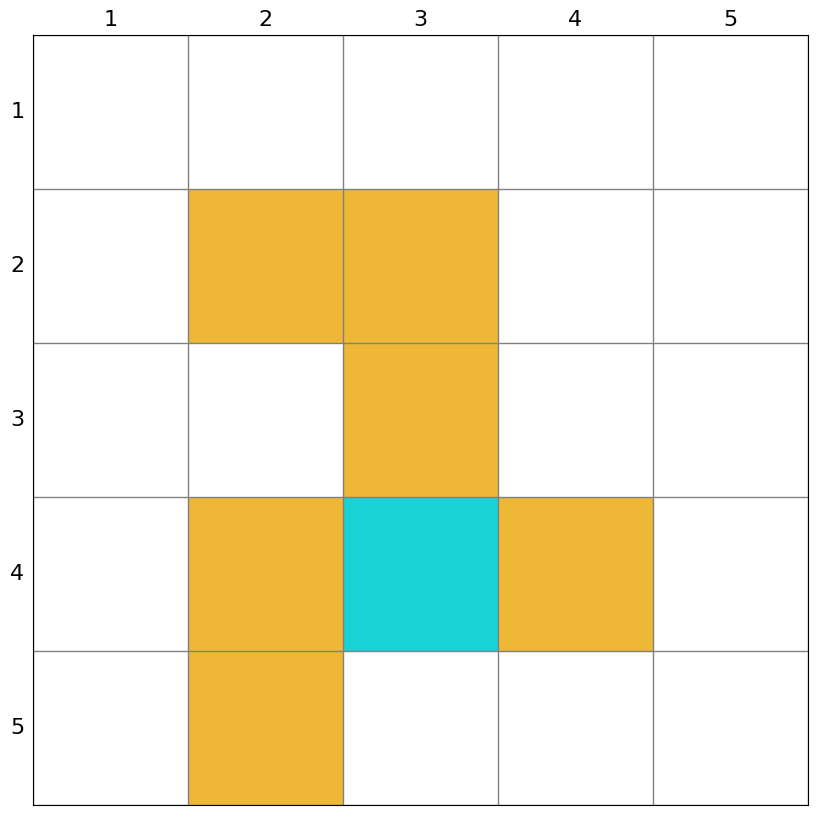

In [36]:
env = grid_env.GridEnv(size=5, target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], render_mode='')

In [39]:
def Sarsa1(env, alpha=0.1, epsilon=0.1, gamma=0.9, num_episodes=1000, decay_rate=0.99, min_epsilon=0.01):
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size

    # 初始化策略为均匀分布
    policy = np.ones((state_space_size, action_space_size)) / action_space_size

    # 初始化Q值为零矩阵
    qvalue = np.zeros((state_space_size, action_space_size))

    # 记录每个回合的总奖励
    episode_rewards = []

    for episode in range(num_episodes):
        env.reset()
        next_state = 0
        done = False
        state = 0  # 重置环境，获取初始状态
        total_reward = 0
        episodes_length = 0

        # 根据epsilon-贪心策略选择初始动作
        action = np.random.choice(np.arange(action_space_size), p=policy[state])

        while not done:
            # 执行动作，获取下一状态、奖励等信息
            _,reward,done,_,_ = env.step(action)
            total_reward += reward
            episodes_length += 1

            # ε-贪心策略选择下一状态的动作
            next_state = env.pos2state(env.agent_location)
            next_action = np.random.choice(np.arange(action_space_size), p=policy[next_state])

            # SARSA更新公式：Q(s, a) = Q(s, a) + alpha * (reward + gamma * Q(s', a') - Q(s, a))
            target = reward + gamma * qvalue[next_state, next_action]
            qvalue[state, action] += alpha * (target - qvalue[state, action])

            # 策略改进（基于ε-贪心策略）
            best_action = np.argmax(qvalue[state])  # 找到当前状态的最优动作
            for a in range(action_space_size):
                if a == best_action:
                    policy[state, a] = 1 - epsilon + epsilon / action_space_size
                else:
                    policy[state, a] = epsilon / action_space_size

            # 更新状态和动作
            state = next_state
            action = next_action

        # 记录每个回合的总奖励
        episode_rewards.append(total_reward)

        # 动态调整epsilon（探索率）和alpha（学习率）
        epsilon = max(min_epsilon, epsilon * decay_rate)  # 衰减epsilon
        alpha = alpha * decay_rate  # 逐渐减小学习率

        # 输出每100回合的训练信息
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

    return policy

In [40]:
def sarsa(alpha=0.1, epsilon=0.1, num_episodes=80 , gamma = 0.1):
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size

    # 初始化策略为均匀分布
    policy = np.ones((state_space_size, action_space_size)) / action_space_size

    # 初始化Q值为零矩阵
    qvalue = np.zeros((state_space_size, action_space_size))

    while num_episodes > 0:
        done = False
        env.reset()
        next_state = 0
        num_episodes -= 1
        total_rewards = 0
        episode_length = 0
        # print(np.linalg.norm(qvalue_list[-1] - qvalue_list[-2], ord=1), num_episodes)
        while not done:
            state = next_state
            action = np.random.choice(np.arange(action_space_size),
                                          p=policy[state])
            _, reward, done, _, _ = env.step(action)
            episode_length += 1
            total_rewards += reward
            next_state = env.pos2state(env.agent_location)
            next_action = np.random.choice(np.arange(action_space_size),
                                               p=policy[next_state])
            target = reward + gamma * qvalue[next_state, next_action]
            error = qvalue[state, action] - target
            qvalue[state, action] = qvalue[state, action] - alpha * error
            qvalue_star = qvalue[state].max()
            action_star = qvalue[state].tolist().index(qvalue_star)
            for a in range(action_space_size):
                if a == action_star:
                    policy[state, a] = 1 - (
                            action_space_size - 1) / action_space_size * epsilon
                else:
                    policy[state, a] = 1 / action_space_size * epsilon
    return policy

In [41]:
policy = Sarsa1(env)

Episode 100, Total Reward: 1, Epsilon: 0.0366
Episode 200, Total Reward: 1, Epsilon: 0.0134
Episode 300, Total Reward: 1, Epsilon: 0.0100
Episode 400, Total Reward: 1, Epsilon: 0.0100
Episode 500, Total Reward: 1, Epsilon: 0.0100
Episode 600, Total Reward: 1, Epsilon: 0.0100
Episode 700, Total Reward: 1, Epsilon: 0.0100
Episode 800, Total Reward: 1, Epsilon: 0.0100
Episode 900, Total Reward: 1, Epsilon: 0.0100
Episode 1000, Total Reward: 1, Epsilon: 0.0100


In [42]:
print(policy)

[[0.002      0.002      0.992      0.002      0.002     ]
 [0.002      0.992      0.002      0.002      0.002     ]
 [0.002      0.002      0.992      0.002      0.002     ]
 [0.002      0.002      0.002      0.992      0.002     ]
 [0.01392826 0.01392826 0.01392826 0.94428694 0.01392826]
 [0.002      0.002      0.992      0.002      0.002     ]
 [0.992      0.002      0.002      0.002      0.002     ]
 [0.992      0.002      0.002      0.002      0.002     ]
 [0.002      0.002      0.992      0.002      0.002     ]
 [0.002      0.002      0.992      0.002      0.002     ]
 [0.002      0.002      0.992      0.002      0.002     ]
 [0.002      0.002      0.992      0.002      0.002     ]
 [0.002      0.992      0.002      0.002      0.002     ]
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.002      0.002      0.002      0.992      0.002     ]
 [0.002      0.992      0.002      0.002      0.002     ]
 [0.002      0.992      0.002      0.002      0.002     ]
 [0.002      0

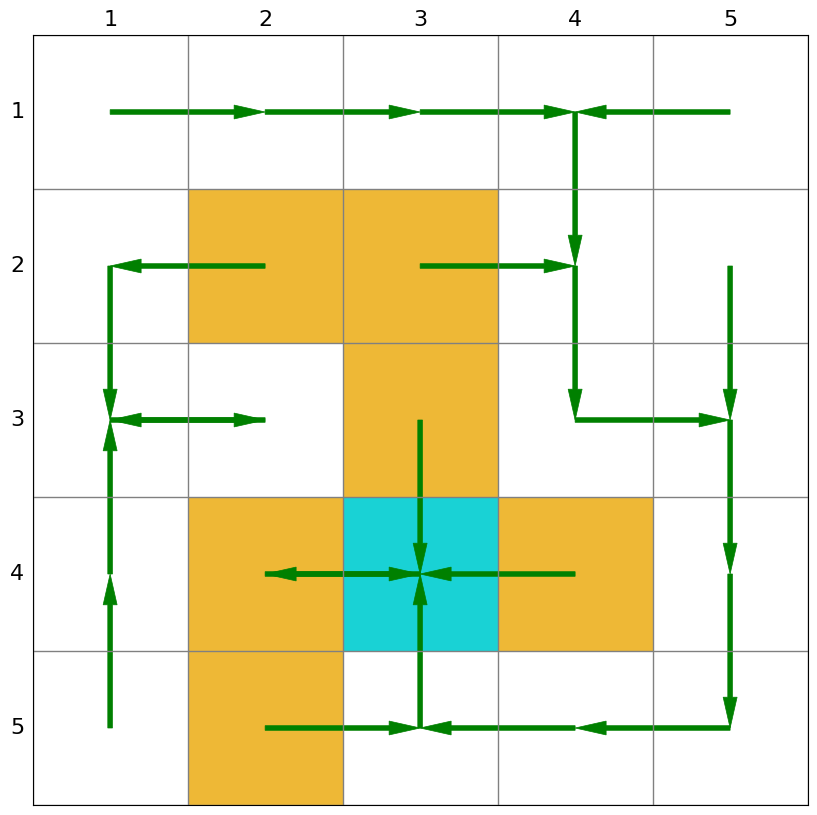

In [43]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], size=5)
# 绘制每个状态的最优动作
for state in range(policy.shape[0]):
    # 计算状态在网格中的位置
    row, col = env.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()